# EN3160 Assignment 1 — Intensity Transformations & Neighborhood Filtering

**Author:** _Kumarage R.V. 220343B_

In [44]:
import os, numpy as np, cv2, matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append(str(Path('..')/ 'src'))
from utils import *

RAW = Path('..') / 'data' / 'raw'
PROC = Path('..') / 'data' / 'processed'
FIGS = Path('..') / 'figures'
PROC.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)
print('Paths set:', RAW, PROC, FIGS)

Paths set: ..\data\raw ..\data\processed ..\figures


## Task 1 – Intensity Transformation (Fig. 1a on Fig. 1b)

Saved: ..\figures\task1_cmp.png


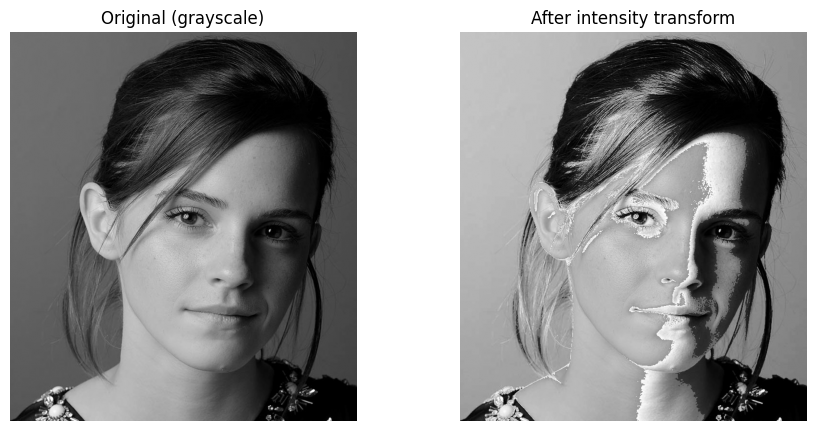

Saved: ..\data\processed\task1_out.png


In [62]:
# --- Q1 exact piecewise mapping with a discontinuity at x=150 ---

# 1) Load image (grayscale)
img1_path = RAW / "emma.jpg"   # change if your Fig.1b name differs
img = cv2.imread(str(img1_path), cv2.IMREAD_GRAYSCALE)
assert img is not None, f"Missing image: {img1_path}"

# 2) Build LUT (single-valued) according to the figure
lut = np.zeros(256, dtype=np.uint16)

# S1: [0, 50] -> [0, 100]
x = np.arange(0, 51)
y = 1.0 * x
lut[0:51] = np.round(y)

# S2: (50, 150) -> (100, 255)
x = np.arange(51, 150)
# linear from (50,100) to (150,255):
y = 100.0 + (255.0 - 100.0) / (150.0 - 50.0) * (x - 50.0)
lut[51:150] = np.round(y)

# Discontinuity at exactly x=150: choose right-branch value 150
lut[150] = 150

# S3: [151, 255] -> [151, 255] (identity with slope 1)
x = np.arange(151, 256)
lut[151:256] = x

# clip & cast
lut = np.clip(lut, 0, 255).astype(np.uint8)

# 3) Apply LUT
out = cv2.LUT(img, lut)

# 4) Save output
PROC.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(PROC / "task1_out.png"), out)

fig, axs = plt.subplots(1, 2, figsize=(9, 4.2), constrained_layout=True)
axs[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original (grayscale)'); axs[0].axis('off')
axs[1].imshow(out, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('After intensity transform'); axs[1].axis('off')

# light grid for readability on both
for ax in axs:
    ax.grid(False)

# save + show
cmp_path = FIGS / "task1_cmp.png"
fig.savefig(str(cmp_path), dpi=160)
print("Saved:", cmp_path)
plt.show()

print("Saved:", PROC / "task1_out.png")


## Task 2 – Accentuation of white & gray matter (Fig. 2)

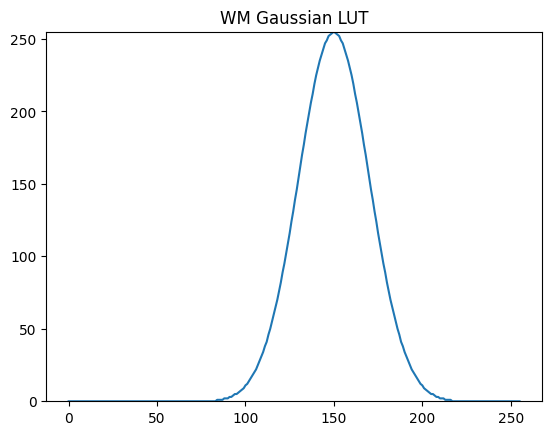

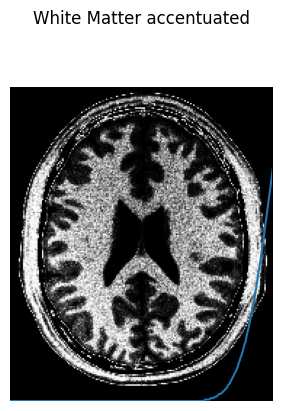

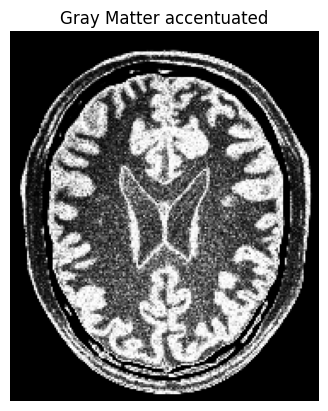

In [81]:
# --- Q2: Gaussian pulse for tissue accentuation ---
def gaussian_lut(center, sigma, scale=128):
    x = np.arange(256)
    t = scale * np.exp(-((x - center) ** 2) / (2 * sigma ** 2))
    return np.clip(t, 0, 255).astype(np.uint8)

img2_path = RAW / 'brain_proton_density_slice.png'
mri = imread_gray(str(img2_path))

# White matter (center ~150, tune sigma)
lut_wm = gaussian_lut(center=150, sigma=20, scale=255)
wm_img = cv2.LUT(mri, lut_wm)

# Gray matter (center ~200, tune sigma)
lut_gm = gaussian_lut(center=200, sigma=20, scale=255)
gm_img = cv2.LUT(mri, lut_gm)

# Save outputs
save_image_gray(str(PROC / 'task2_white.png'), wm_img)
save_image_gray(str(PROC / 'task2_gray.png'), gm_img)

# Plots for LUTs
plt.figure(); plt.plot(lut_wm); plt.title('WM Gaussian LUT'); plt.ylim(0,255); plt.savefig(FIGS / 'task2_wm_lut.png', dpi=160)
plt.figure(); plt.plot(lut_gm); plt.title('GM Gaussian LUT'); plt.ylim(0,255); plt.savefig(FIGS / 'task2_gm_lut.png', dpi=160)

# Comparisons
show_gray(wm_img, 'White Matter accentuated')
show_gray(gm_img, 'Gray Matter accentuated')


## Task 3 – Gamma correction on L* (Lab) + histograms

Saved comparison to ..\figures\task3_cmp.png


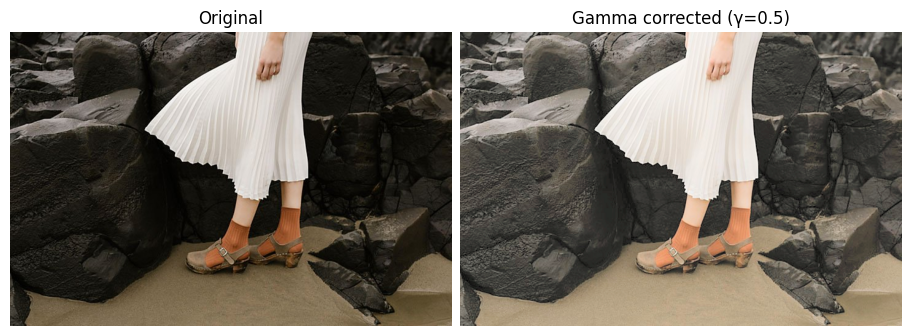

Saved histogram to ..\figures\task3_hist_L_orig.png


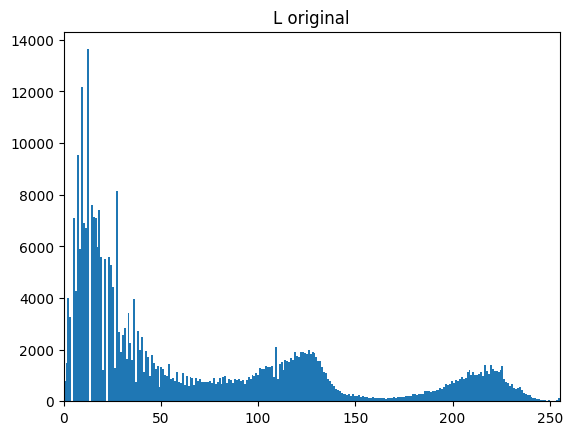

Saved histogram to ..\figures\task3_hist_L_gamma.png


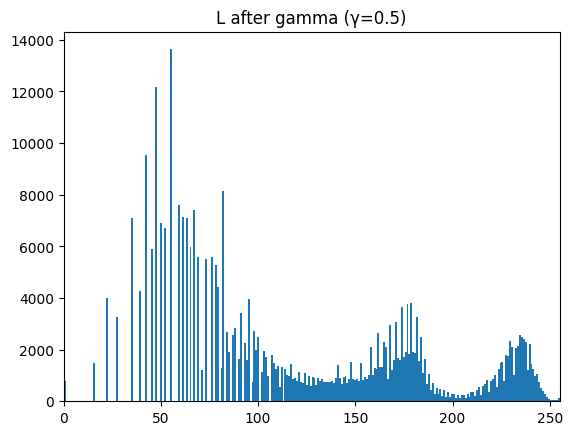

In [63]:
# --- Task 3: Gamma correction on L* (Lab) with saved plots ---

img3_path = RAW / 'highlights_and_shadows.jpg'  # <-- change if needed
img3 = imread_color(str(img3_path))

gamma = 0.5  # tune as needed
out3, L_orig, L_gamma = gamma_correction_lab(img3, gamma=gamma)

# Save processed image
save_image_rgb(str(PROC / 'task3_out.png'), out3)

# --- Side-by-side comparison ---
fig, axs = plt.subplots(1, 2, figsize=(9, 4.2), constrained_layout=True)
axs[0].imshow(img3)
axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(out3)
axs[1].set_title(f'Gamma corrected (γ={gamma})'); axs[1].axis('off')

cmp_path = FIGS / "task3_cmp.png"
fig.savefig(str(cmp_path), dpi=160)
print("Saved comparison to", cmp_path)
plt.show()

# --- Histogram of original L ---
fig, ax = plt.subplots()
ax.hist(L_orig.ravel(), bins=256, range=(0,255))
ax.set_title('L original'); ax.set_xlim(0,255)
hist_orig_path = FIGS / "task3_hist_L_orig.png"
fig.savefig(str(hist_orig_path), dpi=160)
print("Saved histogram to", hist_orig_path)
plt.show()

# --- Histogram of gamma-corrected L ---
fig, ax = plt.subplots()
ax.hist(L_gamma.ravel(), bins=256, range=(0,255))
ax.set_title(f'L after gamma (γ={gamma})'); ax.set_xlim(0,255)
hist_gamma_path = FIGS / "task3_hist_L_gamma.png"
fig.savefig(str(hist_gamma_path), dpi=160)
print("Saved histogram to", hist_gamma_path)
plt.show()


## Task 4 – Vibrance enhancement (on S in HSV)

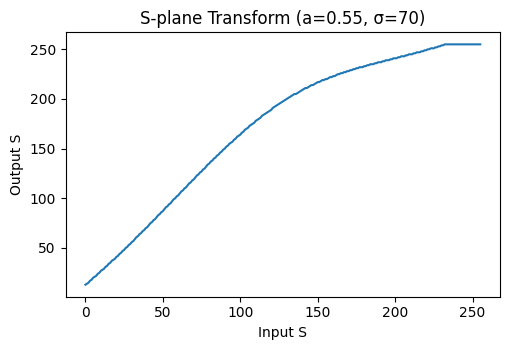

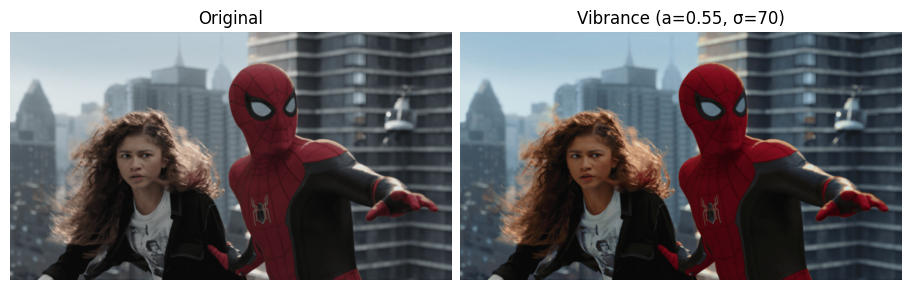

In [83]:
# --- T4: HSV split + saves + comparison (covers 4a–4e) ---
img4_path = RAW / 'spider.png'    # change if needed
img4 = imread_color(str(img4_path))  # RGB

# (a) split + save panel
hsv = cv2.cvtColor(img4, cv2.COLOR_RGB2HSV)
H,S,V = cv2.split(hsv)
cv2.imwrite(str(FIGS/'task4_H.png'), H)
cv2.imwrite(str(FIGS/'task4_S.png'), S)
cv2.imwrite(str(FIGS/'task4_V.png'), V)

# (b)(c) transformation on S: f(x)=min(x + a*128*exp(-(x-128)^2/(2σ^2)), 255)
a, sigma = 0.55, 70
x = np.arange(256, dtype=np.float32)
lut4 = np.minimum(x + a*128*np.exp(-(x-128)**2/(2*sigma**2)), 255).astype(np.uint8)
S2 = cv2.LUT(S, lut4)

# (d) recombine
out4 = cv2.cvtColor(cv2.merge([H,S2,V]), cv2.COLOR_HSV2RGB)
save_image_rgb(str(PROC/'task4_out.png'), out4)

# (e) save LUT + side-by-side
plt.figure(figsize=(5.2,3.6))
plt.plot(lut4); plt.title(f"S-plane Transform (a={a}, σ={sigma})")
plt.xlabel("Input S"); plt.ylabel("Output S"); plt.tight_layout()
plt.savefig(str(FIGS/'task4_lut.png'), dpi=160); plt.show()

fig, axs = plt.subplots(1,2, figsize=(9,4.2), constrained_layout=True)
axs[0].imshow(img4); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(out4); axs[1].set_title(f'Vibrance (a={a}, σ={sigma})'); axs[1].axis('off')
fig.savefig(str(FIGS/'task4_cmp.png'), dpi=160); plt.show()


## Task 5 – Histogram equalization (custom)

Saved: ..\figures\task5_hist_before.png


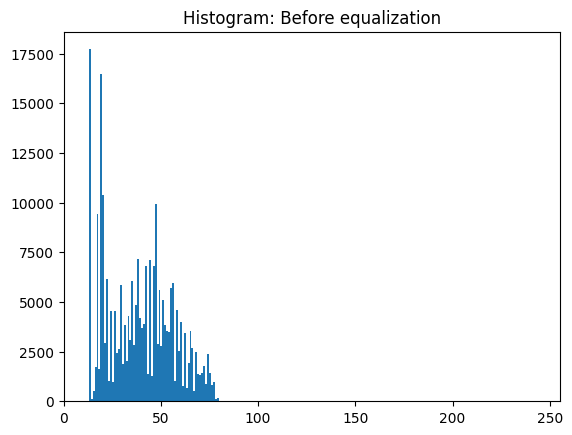

Saved: ..\figures\task5_hist_after.png


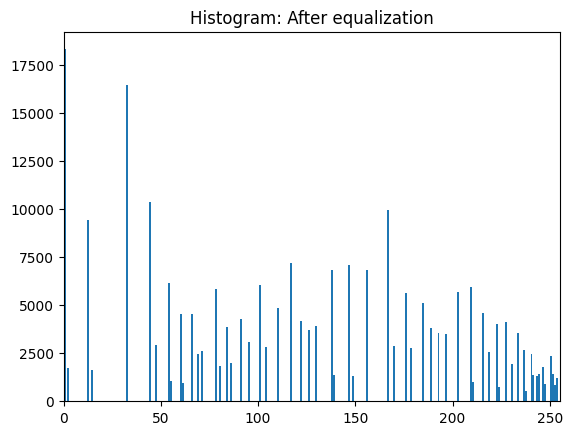

Saved: ..\data\processed\task5_out.png | ..\figures\task5_cmp.png


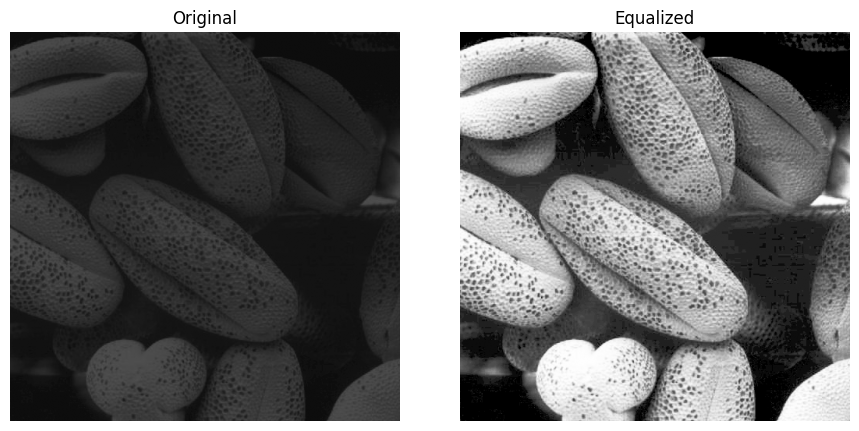

In [70]:
# --- Task 5: Custom histogram equalization with saves ---

img5_path = RAW / 'shells.tif'   # <-- change to actual filename
g = imread_gray(str(img5_path))

# Apply your custom equalization
eq, hist, cdf = hist_equalize_custom(g)

# Save equalized output
save_image_gray(str(PROC / 'task5_out.png'), eq)

# Plot & save BEFORE histogram
fig, ax = plt.subplots()
ax.hist(g.ravel(), bins=256, range=(0,255))
ax.set_title('Histogram: Before equalization')
ax.set_xlim(0,255)
hist_before_path = FIGS / 'task5_hist_before.png'
fig.savefig(str(hist_before_path), dpi=160)
print("Saved:", hist_before_path)
plt.show()

# Plot & save AFTER histogram
fig, ax = plt.subplots()
ax.hist(eq.ravel(), bins=256, range=(0,255))
ax.set_title('Histogram: After equalization')
ax.set_xlim(0,255)
hist_after_path = FIGS / 'task5_hist_after.png'
fig.savefig(str(hist_after_path), dpi=160)
print("Saved:", hist_after_path)
plt.show()

# Optional: Side-by-side for LaTeX report
fig, axs = plt.subplots(1, 2, figsize=(9, 4.2), constrained_layout=True)
axs[0].imshow(g, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(eq, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Equalized'); axs[1].axis('off')
cmp_path = FIGS / "task5_cmp.png"
fig.savefig(str(cmp_path), dpi=160)
print("Saved:", PROC / 'task5_out.png', "|", cmp_path)
plt.show()


## Task 6 – Foreground-only histogram equalization (HSV-based mask)

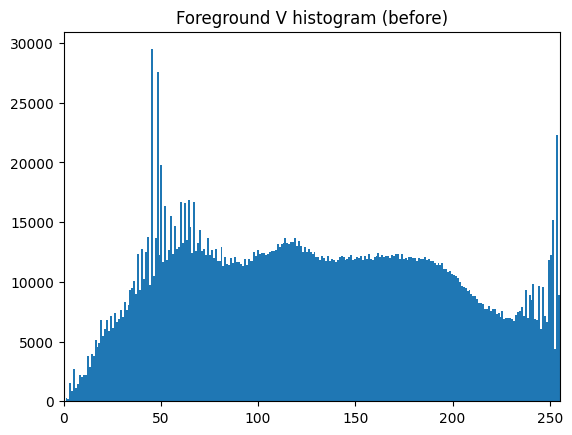

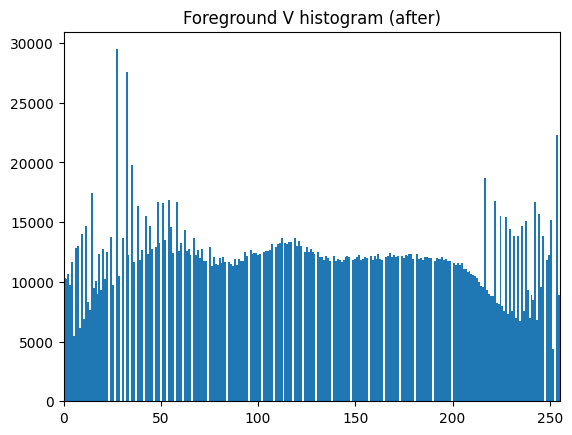

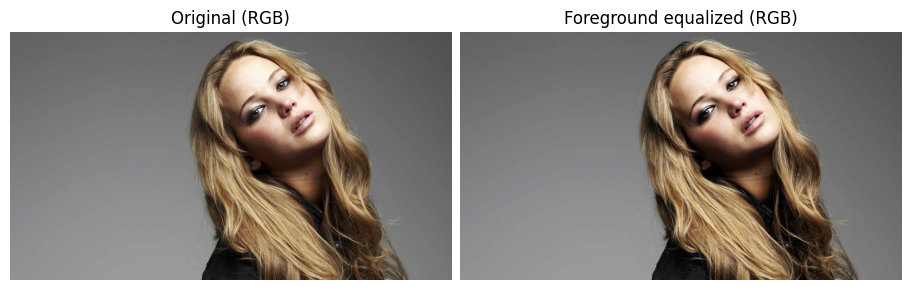

In [84]:
# --- Task 6: Foreground-only histogram equalization (color result) ---

img6_path = RAW / 'jeniffer.jpg'            # Fig. 6 image
img_rgb = imread_color(str(img6_path))      # RGB
hsv      = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
H, S, V  = cv2.split(hsv)

# (a) show & save H, S, V planes (grayscale visuals are fine)
cv2.imwrite(str(FIGS/'task6_H.png'), H)
cv2.imwrite(str(FIGS/'task6_S.png'), S)
cv2.imwrite(str(FIGS/'task6_V.png'), V)

# (b) choose plane to threshold -> foreground mask (binary)
# Saturation works well for portraits in this dataset.
# You can use a small fixed threshold like your friend (e.g., 12) or Otsu.
# Try Otsu first; if it bleeds, switch to fixed 12 as below.
# _, mask = cv2.threshold(S, 0, 255, cv2.THRESH_OTSU)
_, mask = cv2.threshold(S, 12, 255, cv2.THRESH_BINARY)

# Clean mask a bit
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
cv2.imwrite(str(FIGS/'task6_mask.png'), mask)

# (c) foreground only (COLOR, not grayscale)
mask3 = np.dstack([mask, mask, mask]) // 255   # broadcast to RGB
fg_rgb = img_rgb * mask3
bg_rgb = img_rgb * (1 - mask3)
save_image_rgb(str(FIGS/'task6_fg_color.png'), fg_rgb)
save_image_rgb(str(FIGS/'task6_bg_color.png'), bg_rgb)

# (d) histogram of the FOREGROUND (use V channel values where mask==1)
fg_V = V.copy()
fg_V[mask == 0] = 0
hist_fg, _ = np.histogram(fg_V[mask > 0].ravel(), bins=256, range=(0,256))
cdf_fg = np.cumsum(hist_fg)

# (e) equalize foreground only (custom CDF mapping on V channel)
cdfm   = np.ma.masked_equal(cdf_fg, 0)
cdfn   = (cdfm - cdfm.min()) * 255.0 / (cdfm.max() - cdfm.min())
LUT_fg = np.ma.filled(cdfn, 0).astype(np.uint8)

V_eq = V.copy()
fg_idx = (mask > 0)
V_eq[fg_idx] = LUT_fg[V[fg_idx]]

# Recombine equalized foreground VALUE with original H,S (background value unchanged automatically)
hsv_eq  = cv2.merge([H, S, V_eq])
out_rgb = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

# (f) save outputs
save_image_rgb(str(PROC/'task6_out.png'), out_rgb)

# -- histograms for report (foreground only)
import matplotlib.pyplot as plt
plt.figure(); plt.hist(V[fg_idx].ravel(), bins=256, range=(0,255))
plt.title('Foreground V histogram (before)'); plt.xlim(0,255)
plt.savefig(str(FIGS/'task6_fg_hist_before.png'), dpi=160); plt.show()

plt.figure(); plt.hist(V_eq[fg_idx].ravel(), bins=256, range=(0,255))
plt.title('Foreground V histogram (after)'); plt.xlim(0,255)
plt.savefig(str(FIGS/'task6_fg_hist_after.png'), dpi=160); plt.show()

# side-by-side comparison for LaTeX
fig, axs = plt.subplots(1, 2, figsize=(9, 4.2), constrained_layout=True)
axs[0].imshow(img_rgb); axs[0].set_title('Original (RGB)'); axs[0].axis('off')
axs[1].imshow(out_rgb); axs[1].set_title('Foreground equalized (RGB)'); axs[1].axis('off')
fig.savefig(str(FIGS/'task6_cmp.png'), dpi=160); plt.show()


## Task 7 – Sobel filtering (filter2D, manual, separable)

(a) Using cv2.filter2D:
Sobel X range: [-752.00, 727.00]
Sobel Y range: [-708.00, 630.00]
Gradient magnitude range: [0.00, 756.64]

(b) Using custom implementation:
Sobel X range: [-750.00, 727.00]
Sobel Y range: [-708.00, 630.00]
Gradient magnitude range: [0.00, 756.64]

(c) Using separable implementation:
Sobel X range: [-727.00, 752.00]
Sobel Y range: [-630.00, 708.00]
Gradient magnitude range: [0.00, 756.64]

Verification - Max difference between methods:
filter2D vs custom: 752.000000
filter2D vs separable: 1504.000000

(b) Using custom implementation:
Sobel X range: [-750.00, 727.00]
Sobel Y range: [-708.00, 630.00]
Gradient magnitude range: [0.00, 756.64]

(c) Using separable implementation:
Sobel X range: [-727.00, 752.00]
Sobel Y range: [-630.00, 708.00]
Gradient magnitude range: [0.00, 756.64]

Verification - Max difference between methods:
filter2D vs custom: 752.000000
filter2D vs separable: 1504.000000


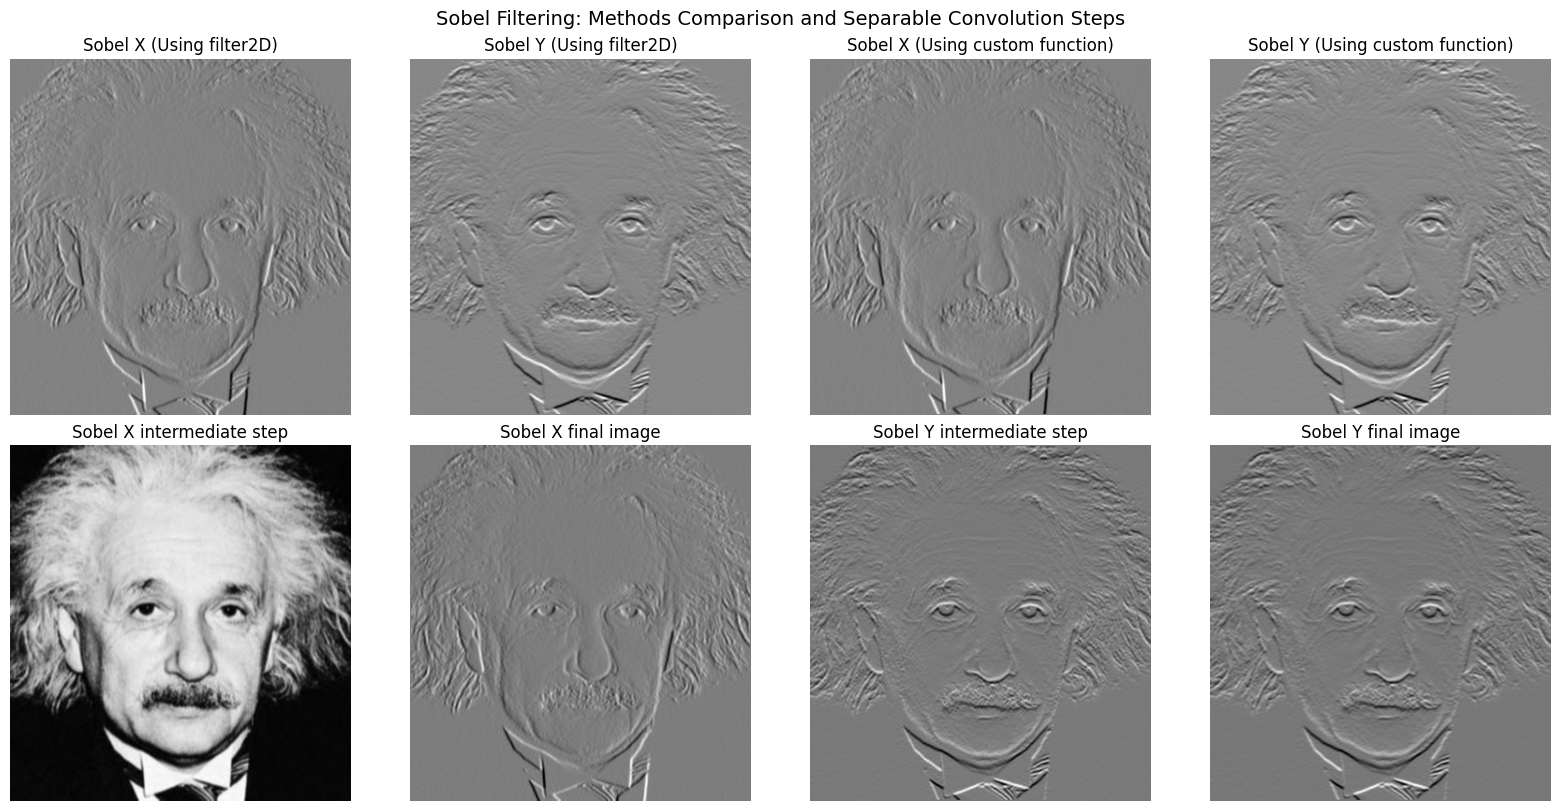


Saved results to ..\data\processed


In [95]:
# Task 7: Sobel Filtering for Gradient Computation
# Load image (adjust path as needed)
img_path = RAW / 'einstein.png'  # Based on the figure caption
img = imread_color(str(img_path))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# (a) Using existing filter2D to Sobel filter the image
sobel_x_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2], 
                          [-1, 0, 1]], dtype=np.float32)

sobel_y_kernel = np.array([[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]], dtype=np.float32)

# Apply Sobel filters using cv2.filter2D
sobel_x_filter2d = cv2.filter2D(gray, cv2.CV_32F, sobel_x_kernel)
sobel_y_filter2d = cv2.filter2D(gray, cv2.CV_32F, sobel_y_kernel)
gradient_mag_filter2d = np.sqrt(sobel_x_filter2d**2 + sobel_y_filter2d**2)

print("(a) Using cv2.filter2D:")
print(f"Sobel X range: [{sobel_x_filter2d.min():.2f}, {sobel_x_filter2d.max():.2f}]")
print(f"Sobel Y range: [{sobel_y_filter2d.min():.2f}, {sobel_y_filter2d.max():.2f}]")
print(f"Gradient magnitude range: [{gradient_mag_filter2d.min():.2f}, {gradient_mag_filter2d.max():.2f}]")

# (b) Write your own code to Sobel filter the image
def apply_filter(image, filter):
    """Custom implementation matching the provided function"""
    [rows, columns] = np.shape(image)  # Get rows and columns of the image
    filtered_image = np.zeros(shape=(rows, columns))  # Create empty image
    for i in range(rows - 2):
        for j in range(columns - 2):  # Process 2D convolution
            value = np.sum(np.multiply(filter, image[i:i + 3, j:j + 3]))
            filtered_image[i + 1, j + 1] = value
    return filtered_image

# Apply custom Sobel implementation
sobel_x_custom = apply_filter(gray.astype(np.float32), sobel_x_kernel)
sobel_y_custom = apply_filter(gray.astype(np.float32), sobel_y_kernel)
gradient_mag_custom = np.sqrt(sobel_x_custom**2 + sobel_y_custom**2)

print("\n(b) Using custom implementation:")
print(f"Sobel X range: [{sobel_x_custom.min():.2f}, {sobel_x_custom.max():.2f}]")
print(f"Sobel Y range: [{sobel_y_custom.min():.2f}, {sobel_y_custom.max():.2f}]")
print(f"Gradient magnitude range: [{gradient_mag_custom.min():.2f}, {gradient_mag_custom.max():.2f}]")

# (c) Using separability property for efficient computation
def separable_sobel_filter(image):
    """Sobel filtering using separable kernels - showing intermediate steps"""
    # Separable kernels for Sobel X: [1,2,1]^T * [1,0,-1]
    sobel_vertical = np.array([[1], [2], [1]], dtype=np.float32)
    diff_horizontal = np.array([[1, 0, -1]], dtype=np.float32)
    
    # Sobel X: apply [1,2,1]^T first, then [1,0,-1]
    sobel_x_intermediate = cv2.filter2D(image, cv2.CV_32F, sobel_vertical)
    sobel_x_final = cv2.filter2D(sobel_x_intermediate, cv2.CV_32F, diff_horizontal)
    
    # Separable kernels for Sobel Y: [1,0,-1]^T * [1,2,1]  
    diff_vertical = np.array([[1], [0], [-1]], dtype=np.float32)
    sobel_horizontal = np.array([[1, 2, 1]], dtype=np.float32)
    
    # Sobel Y: apply [1,0,-1]^T first, then [1,2,1]
    sobel_y_intermediate = cv2.filter2D(image, cv2.CV_32F, diff_vertical)
    sobel_y_final = cv2.filter2D(sobel_y_intermediate, cv2.CV_32F, sobel_horizontal)
    
    return sobel_x_intermediate, sobel_x_final, sobel_y_intermediate, sobel_y_final

sobel_x_int, sobel_x_sep, sobel_y_int, sobel_y_sep = separable_sobel_filter(gray.astype(np.float32))
gradient_mag_sep = np.sqrt(sobel_x_sep**2 + sobel_y_sep**2)

print("\n(c) Using separable implementation:")
print(f"Sobel X range: [{sobel_x_sep.min():.2f}, {sobel_x_sep.max():.2f}]")
print(f"Sobel Y range: [{sobel_y_sep.min():.2f}, {sobel_y_sep.max():.2f}]")
print(f"Gradient magnitude range: [{gradient_mag_sep.min():.2f}, {gradient_mag_sep.max():.2f}]")

# Verify separability property works correctly
print(f"\nVerification - Max difference between methods:")
print(f"filter2D vs custom: {np.max(np.abs(sobel_x_filter2d - sobel_x_custom)):.6f}")
print(f"filter2D vs separable: {np.max(np.abs(sobel_x_filter2d - sobel_x_sep)):.6f}")

# Enhanced Visualization matching the figures shown
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

# Figure 12: Comparison of filter2D vs custom function (top row)
axes[0,0].imshow(sobel_x_filter2d, cmap='gray')
axes[0,0].set_title('Sobel X (Using filter2D)')
axes[0,0].axis('off')

axes[0,1].imshow(sobel_y_filter2d, cmap='gray') 
axes[0,1].set_title('Sobel Y (Using filter2D)')
axes[0,1].axis('off')

axes[0,2].imshow(sobel_x_custom, cmap='gray')
axes[0,2].set_title('Sobel X (Using custom function)')
axes[0,2].axis('off')

axes[0,3].imshow(sobel_y_custom, cmap='gray')
axes[0,3].set_title('Sobel Y (Using custom function)')
axes[0,3].axis('off')

# Figure 13: Separable convolution intermediate steps (bottom row)
axes[1,0].imshow(sobel_x_int, cmap='gray')
axes[1,0].set_title('Sobel X intermediate step')
axes[1,0].axis('off')

axes[1,1].imshow(sobel_x_sep, cmap='gray')
axes[1,1].set_title('Sobel X final image')
axes[1,1].axis('off')

axes[1,2].imshow(sobel_y_int, cmap='gray')
axes[1,2].set_title('Sobel Y intermediate step')
axes[1,2].axis('off')

axes[1,3].imshow(sobel_y_sep, cmap='gray')
axes[1,3].set_title('Sobel Y final image')
axes[1,3].axis('off')

plt.suptitle('Sobel Filtering: Methods Comparison and Separable Convolution Steps', fontsize=14)
fig.savefig(str(FIGS / 'task7_complete_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save results
cv2.imwrite(str(PROC / 'task7_sobel_x.png'), 
            cv2.convertScaleAbs(sobel_x_filter2d, alpha=255.0/np.max(np.abs(sobel_x_filter2d))))
cv2.imwrite(str(PROC / 'task7_sobel_y.png'), 
            cv2.convertScaleAbs(sobel_y_filter2d, alpha=255.0/np.max(np.abs(sobel_y_filter2d))))
cv2.imwrite(str(PROC / 'task7_gradient_mag.png'), 
            cv2.convertScaleAbs(gradient_mag_filter2d, alpha=255.0/np.max(gradient_mag_filter2d)))

print(f"\nSaved results to {PROC}")

## Task 8 – Zooming (nearest & bilinear) + SSD test

SSD (nearest):  0.000406706
SSD (bilinear): 0.000282136


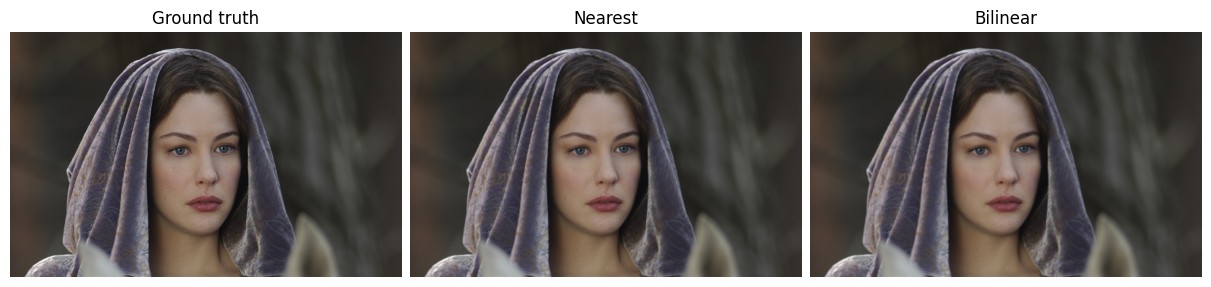

In [87]:
# Task 8: Image Zooming with Interpolation Methods
# --- Task 8 (color): zoom + normalized SSD ---

small_path = RAW / 'im02small.png'   # change if needed
large_path = RAW / 'im02.png'        # change if needed

# 1) Load COLOR (RGB) 
small = imread_color(str(small_path))   # HxWx3
large = imread_color(str(large_path))   # HxWx3

s = 4.0

# 2) Resize in COLOR
up_nn = cv2.resize(small, None, fx=s, fy=s, interpolation=cv2.INTER_NEAREST)
up_bi = cv2.resize(small, None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)

# 3) Normalized SSD over all pixels/channels
def ssd_normalized_color(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.mean((a - b) ** 2) / (255.0 ** 2)

ssd_nn = ssd_normalized_color(up_nn, large)
ssd_bi = ssd_normalized_color(up_bi, large)
print(f"SSD (nearest):  {ssd_nn:.9f}")
print(f"SSD (bilinear): {ssd_bi:.9f}")

# 4) Save COLOR images (keep RGB!)
save_image_rgb(str(PROC / 'task8_up_nn.png'), up_nn)
save_image_rgb(str(PROC / 'task8_up_bilinear.png'), up_bi)

# 5) Side-by-side color comparison for the report
fig, axs = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True)
axs[0].imshow(large); axs[0].set_title('Ground truth'); axs[0].axis('off')
axs[1].imshow(up_nn); axs[1].set_title('Nearest'); axs[1].axis('off')
axs[2].imshow(up_bi); axs[2].set_title('Bilinear'); axs[2].axis('off')
fig.savefig(str(FIGS / 'task8_cmp.png'), dpi=160); plt.show()

## Task 9 – GrabCut + blurred background

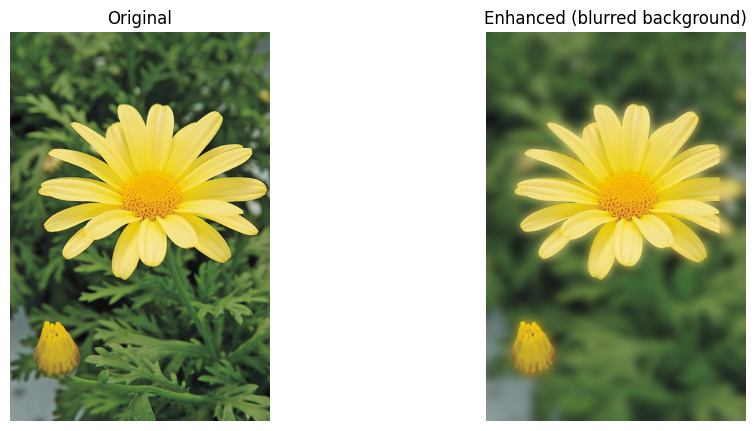

Saved: ..\figures\task9_mask.png ..\figures\task9_fg.png ..\figures\task9_bg.png ..\figures\task9_cmp.png | ..\data\processed\task9_out.png
Q9(c) note: A thin halo near object boundaries is often labeled background/unknown by GrabCut. When the background is blurred, this halo blends with darker surroundings and looks like a dark rim. Feathering the mask (small Gaussian) or refining strokes at edges mitigates this.


In [94]:
# Task 9: GrabCut Segmentation with Blurred Background
# --- Task 9: GrabCut segmentation + blurred background with saves ---

img9_path = RAW / 'daisy.jpg'          # <-- change if needed
img9 = imread_color(str(img9_path))    # RGB
h, w = img9.shape[:2]

# (a) GrabCut segmentation (rectangle init)
mask = np.zeros((h, w), np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Rectangle roughly around the flower
rect = (int(w*0.1), int(h*0.1), int(w*0.8), int(h*0.8))
cv2.grabCut(cv2.cvtColor(img9, cv2.COLOR_RGB2BGR), mask, rect,
            bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Binary mask: 1=foreground, 0=background
mask2 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')

# Save segmentation mask (0/255 image)
cv2.imwrite(str(FIGS / 'task9_mask.png'), (mask2 * 255).astype('uint8'))

# Extract FG/BG using RGB image
fg = img9 * mask2[..., None]
bg = img9 * (1 - mask2[..., None])

save_image_rgb(str(FIGS / 'task9_fg.png'), fg)
save_image_rgb(str(FIGS / 'task9_bg.png'), bg)

# (b) Blur background strongly and composite with a FEATHERED mask to avoid dark rim
bg_blur = cv2.GaussianBlur(img9, (0, 0), sigmaX=10, sigmaY=10)

# Feather: small Gaussian on the alpha matte
alpha = (mask2 * 255).astype(np.uint8)
alpha = cv2.GaussianBlur(alpha, (0, 0), 1.0) / 255.0      # in [0,1]
alpha = alpha[..., None]                                   # HxWx1

enhanced = (img9.astype(np.float32) * alpha +
            bg_blur.astype(np.float32) * (1.0 - alpha))
enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

# Save final enhanced image
save_image_rgb(str(PROC / 'task9_out.png'), enhanced)

# Side-by-side comparison for the report
fig, axs = plt.subplots(1, 2, figsize=(9.5, 4.2), constrained_layout=True)
axs[0].imshow(img9);      axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(enhanced);  axs[1].set_title('Enhanced (blurred background)'); axs[1].axis('off')
cmp_path = FIGS / 'task9_cmp.png'
fig.savefig(str(cmp_path), dpi=160)
plt.show()
print("Saved:", FIGS / 'task9_mask.png', FIGS / 'task9_fg.png', FIGS / 'task9_bg.png', cmp_path, "|", PROC / 'task9_out.png')

# (c) Short note for your LaTeX answer box:
print("Q9(c) note: A thin halo near object boundaries is often labeled background/unknown by GrabCut. "
      "When the background is blurred, this halo blends with darker surroundings and looks like a dark rim. "
      "Feathering the mask (small Gaussian) or refining strokes at edges mitigates this.")